In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pywt
import seaborn as sns
import csv
import glob
import librosa as librosa
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score
import time
import warnings
from scipy.signal import spectrogram

In [4]:
def merge_csi_label(csifile, labelfile, win_len=1000, step=200):
    """
    Merge CSV files into a Numpy Array  X,  csi amplitude feature
    Returns Numpy Array X, Shape(Num, Win_Len, 90)
    Args:
        csifile  :  str, csv file containing CSI data
        labelfile:  str, csv fiel with activity label 
        win_len  :  integer, window length
        thrshd   :  float,  determine if an activity is strong enough inside a window
        step     :  integer, sliding window by step
    """
    activity_count = []
    activity =[]
    with open(labelfile, 'r') as labelf:
        reader = csv.reader(labelf)
        for line in reader:
            activity.append(line[0])
    activity = pd.DataFrame(np.array(activity))
    csi = []
    with open(csifile, 'r') as csif:
        reader = csv.reader(csif)
        for line in reader:
            line_array = np.array([float(v) for v in line])
            # extract the amplitude only
            line_array = line_array[1:91]
            csi.append(line_array[np.newaxis,...])
    csi = np.concatenate(csi, axis=0)
    csi = np.array(csi)
    
    pca_filtred_data=pca_filtering(csi)
    
    DWT_features_200ms=DWT_feature_extraction(pca_filtred_data,200,levels=12)

    return pca_filtred_data,DWT_features_200ms

In [5]:
def pca_filtering(amp):
    constant_offset = np.empty_like(amp)
    filtered_data = np.empty_like(amp)

    for i in range(1,len(amp[0])):
        constant_offset[:,i] = moving_average(amp[:,i],400)

    filtered_data = amp - constant_offset

    for i in range(1,len(amp[0])):
        filtered_data[:,i] = moving_average(filtered_data[:,i],100)

        #eigen value cal
    con_mat = np.cov(filtered_data.T)
    eig_val,eig_vec = np.linalg.eig(con_mat) 
    idx = eig_val.argsort()[::-1]
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:,idx]
    pca_data = filtered_data.dot(eig_vec)

    outliers_removed = np.empty_like(pca_data[:,1:6])


    for i in range(1,6):
        res, detected_outliers = hampel_filter_forloop(pca_data[:,i], 10)
        outliers_removed[:,i-1] = res


    return outliers_removed

In [6]:
def DWT_feature_extraction(a,time_ms,levels=5):
    empty_df = pd.DataFrame()
    for j in range(0,5):
        for i in range (0,len(a[:,0]),int(time_ms)):
            if i==0:
                test=np.array(compute_dwt_energy(a[i:i+int(time_ms),j], wavelet='db5', levels=levels))
            else:
                test_1=np.array(compute_dwt_energy(a[i:i+int(time_ms),j], wavelet='db5', levels=levels))
                test= np.append(test,test_1)
       
    
        empty_df = empty_df.append(pd.Series(test), ignore_index=True)
    mean_df=(pd.DataFrame(empty_df.mean())).T
    
    a=(mean_df).values
    DWT_features_200ms=pd.DataFrame()
    for k in range (0,a.shape[1],12):
        DWT_features_200ms = pd.concat([DWT_features_200ms, pd.DataFrame(a[:,k:k+12].ravel()).T], axis=0, ignore_index=True)
    return DWT_features_200ms



In [7]:
def compute_dwt_energy(signal, wavelet='db5', levels=None):
    # Perform the DWT on the signal
    coeffs = pywt.wavedec(signal, wavelet, level=levels)
    
    # Compute energy for each level
    energy_per_level = []
    for level in range(1, len(coeffs)):
        level_energy = sum(coef**2 for coef in coeffs[level])
        energy_per_level.append(level_energy)
    
    return energy_per_level

In [9]:
def moving_average(data,window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data,window,'same')

In [11]:
def hampel_filter_forloop(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

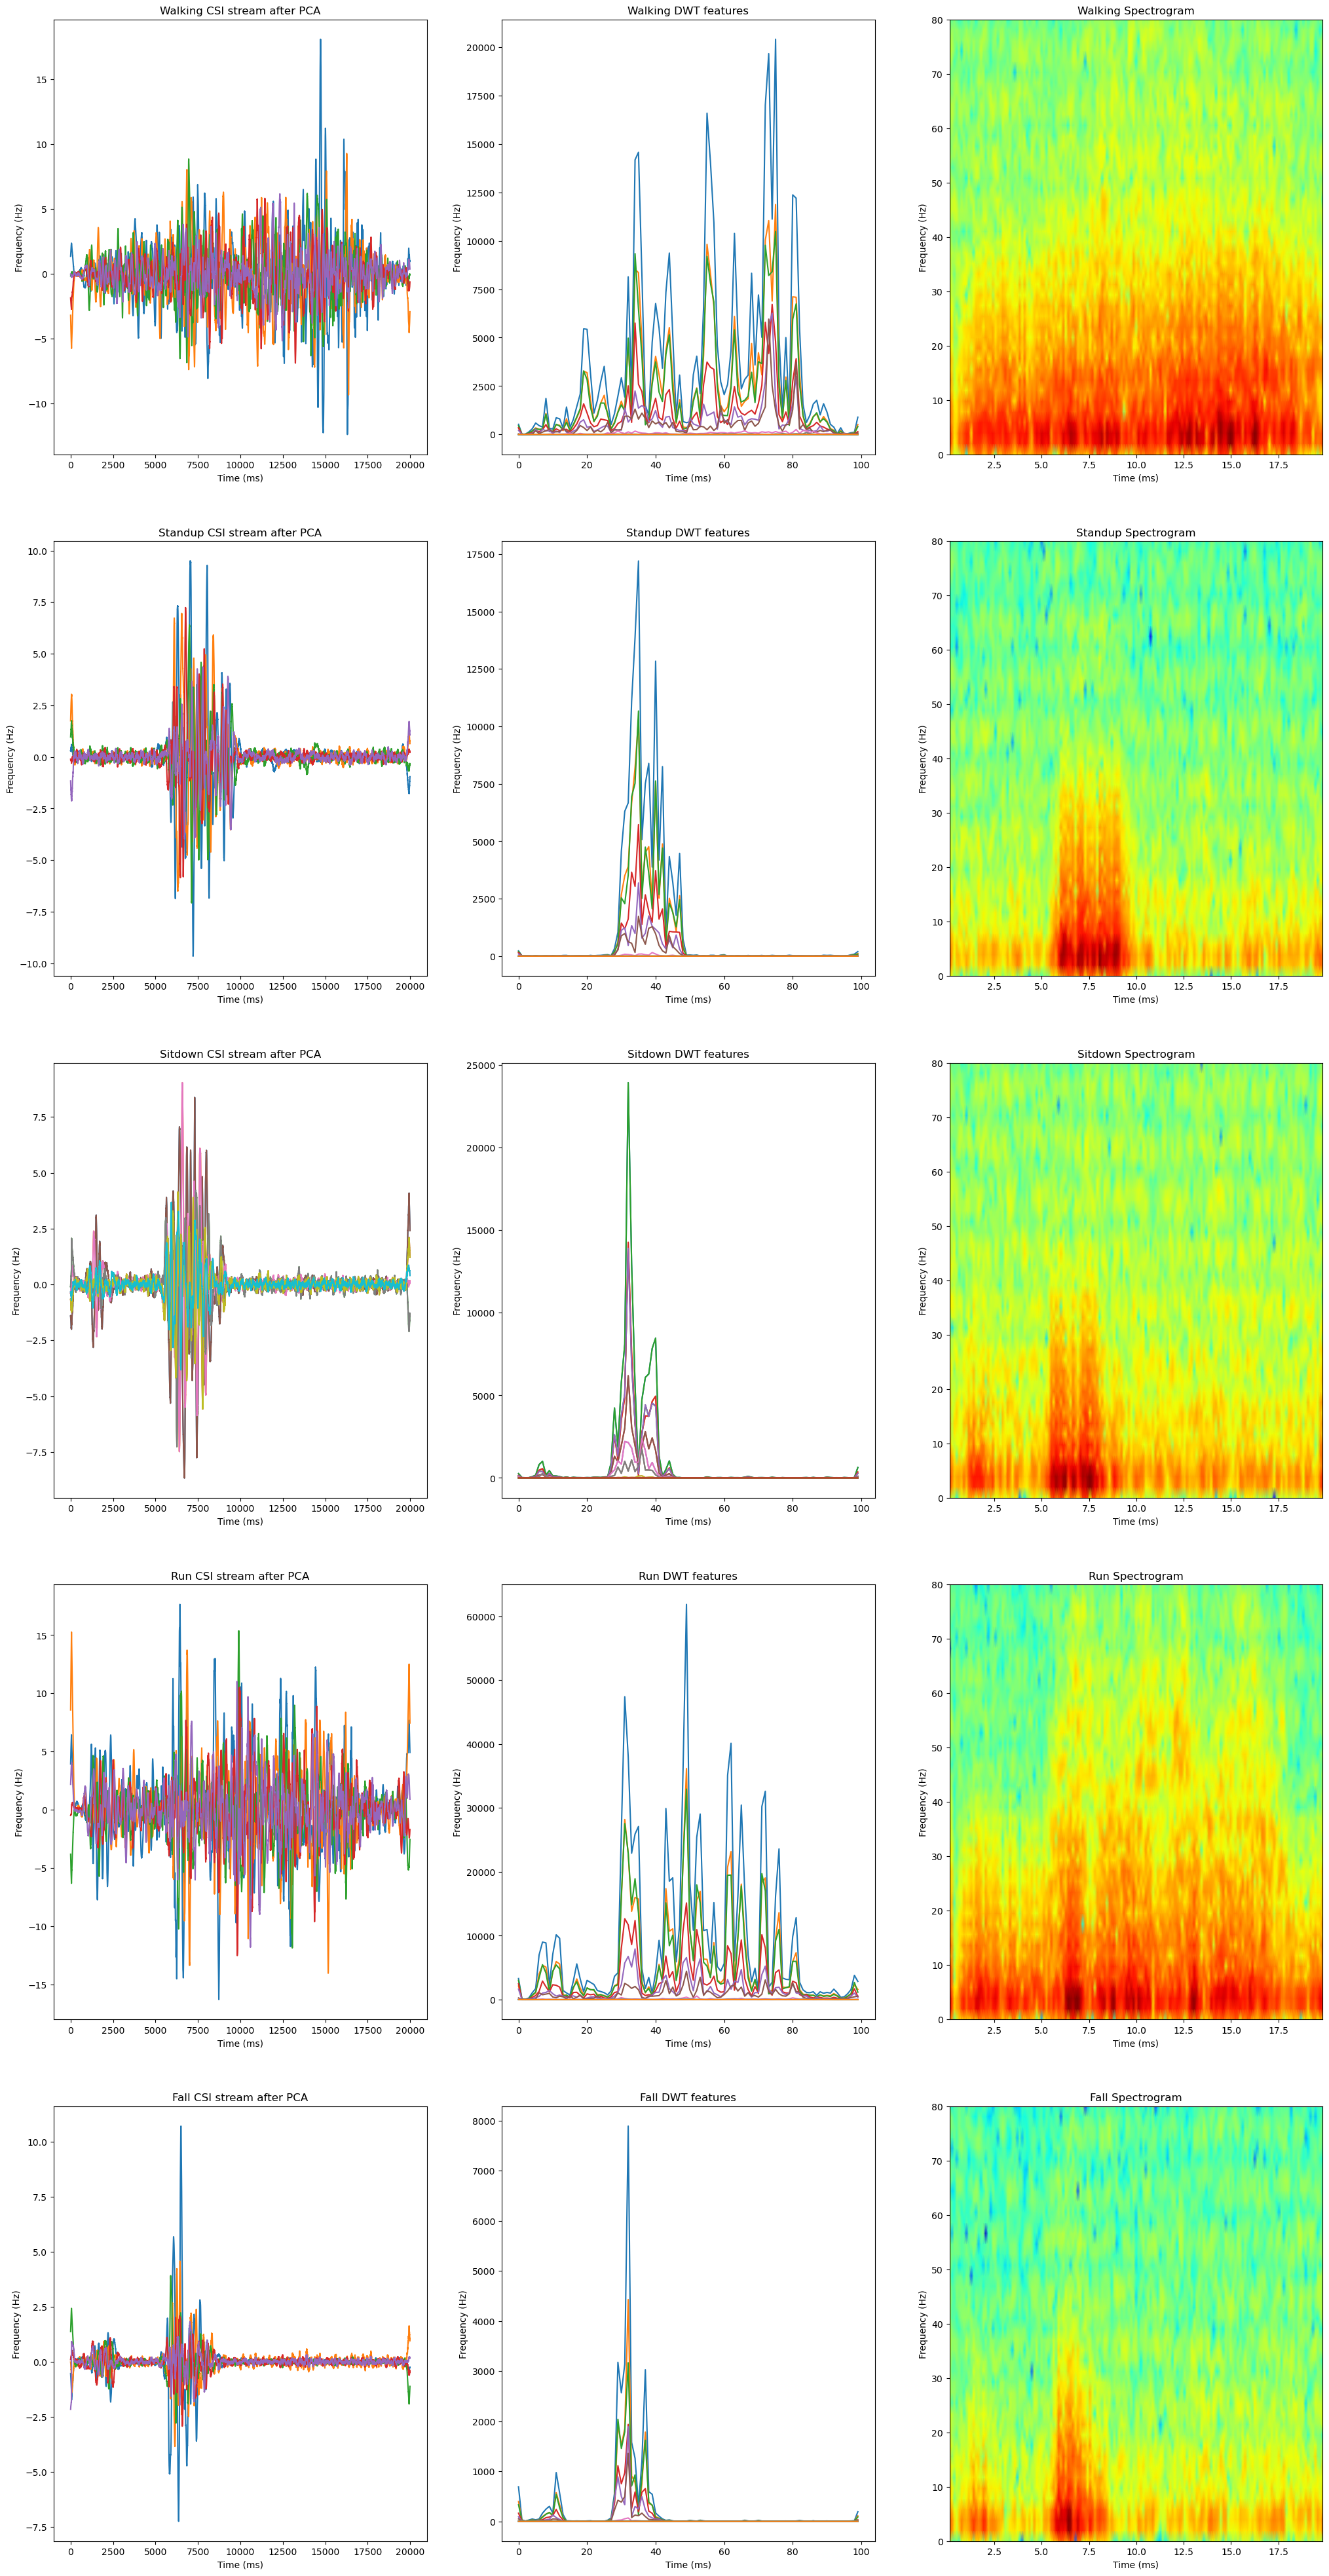

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
warnings.filterwarnings("ignore")
plt.figure(figsize=(25, 50))

#walking
csifile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/input_sankalp_walk_3.csv'
labelfile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/annotation_sankalp_fall_1.csv'
pca_filtred_data,DWT_features_200ms= merge_csi_label(csifile, labelfile, win_len=1000, step=200)

plt.subplot(5, 3, 1)
plt.plot(pca_filtred_data)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Walking CSI stream after PCA')

plt.subplot(5, 3, 2)
plt.plot(DWT_features_200ms)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Walking DWT features')

plt.subplot(5, 3, 3)

Fs = 1000  # Sampling frequency
t = np.arange(0, 5, 1/Fs)  # Time vector



f_spec, t_spec, Sxx = spectrogram(np.average(pca_filtred_data,axis=1), fs=Fs, nperseg=256, noverlap=128, nfft=512)
plt.pcolormesh(t_spec, f_spec, 10*np.log10(Sxx), shading='gouraud', cmap='jet')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Walking Spectrogram')
plt.ylim(0, 80) 



#Standup
csifile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/input_siamak_standup_9.csv'
labelfile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/annotation_siamak_standup_9.csv'
pca_filtred_data,DWT_features_200ms= merge_csi_label(csifile, labelfile, win_len=1000, step=200)

plt.subplot(5, 3, 4)
plt.plot(pca_filtred_data)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Standup CSI stream after PCA')

plt.subplot(5, 3, 5)
plt.plot(DWT_features_200ms)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Standup DWT features')

plt.subplot(5, 3, 6)

Fs = 1000  # Sampling frequency
t = np.arange(0, 5, 1/Fs)  # Time vector



f_spec, t_spec, Sxx = spectrogram(np.average(pca_filtred_data,axis=1), fs=Fs, nperseg=256, noverlap=128, nfft=512)
plt.pcolormesh(t_spec, f_spec, 10*np.log10(Sxx), shading='gouraud', cmap='jet')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Standup Spectrogram')
plt.ylim(0, 80)  



#Sitdown
csifile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/input_siamak_sitdown_1.csv'
labelfile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/annotation_siamak_sitdown_1.csv'
pca_filtred_data,DWT_features_200ms= merge_csi_label(csifile, labelfile, win_len=1000, step=200)

plt.subplot(5, 3, 7)
plt.plot(pca_filtred_data)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Sitdown CSI stream after PCA')

plt.subplot(5, 3, 8)
plt.plot(DWT_features_200ms)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Sitdown DWT features')

plt.subplot(5, 3, 9)

Fs = 1000  # Sampling frequency
t = np.arange(0, 5, 1/Fs)  # Time vector



f_spec, t_spec, Sxx = spectrogram(np.average(pca_filtred_data,axis=1), fs=Fs, nperseg=256, noverlap=128, nfft=512)
plt.pcolormesh(t_spec, f_spec, 10*np.log10(Sxx), shading='gouraud', cmap='jet')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Sitdown Spectrogram')
plt.ylim(0, 80)  


#Sitdown
csifile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/input_siamak_sitdown_1.csv'
labelfile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/annotation_siamak_sitdown_1.csv'
pca_filtred_data,DWT_features_200ms= merge_csi_label(csifile, labelfile, win_len=1000, step=200)

plt.subplot(5, 3, 7)
plt.plot(pca_filtred_data)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Sitdown CSI stream after PCA')

plt.subplot(5, 3, 8)
plt.plot(DWT_features_200ms)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Sitdown DWT features')

plt.subplot(5, 3, 9)

Fs = 1000  # Sampling frequency
t = np.arange(0, 5, 1/Fs)  # Time vector



f_spec, t_spec, Sxx = spectrogram(np.average(pca_filtred_data,axis=1), fs=Fs, nperseg=256, noverlap=128, nfft=512)
plt.pcolormesh(t_spec, f_spec, 10*np.log10(Sxx), shading='gouraud', cmap='jet')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Sitdown Spectrogram')
plt.ylim(0, 80)  



#Run
csifile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/input_siamak_run_3.csv'
labelfile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/annotation_siamak_run_3.csv'
pca_filtred_data,DWT_features_200ms= merge_csi_label(csifile, labelfile, win_len=1000, step=200)

plt.subplot(5, 3, 10)
plt.plot(pca_filtred_data)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Run CSI stream after PCA')

plt.subplot(5, 3, 11)
plt.plot(DWT_features_200ms)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Run DWT features')

plt.subplot(5, 3, 12)

Fs = 1000  # Sampling frequency
t = np.arange(0, 5, 1/Fs)  # Time vector



f_spec, t_spec, Sxx = spectrogram(np.average(pca_filtred_data,axis=1), fs=Fs, nperseg=256, noverlap=128, nfft=512)
plt.pcolormesh(t_spec, f_spec, 10*np.log10(Sxx), shading='gouraud', cmap='jet')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Run Spectrogram')
plt.ylim(0, 80) 


#Fall
csifile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/input_sankalp_fall_3.csv'
labelfile='/Users/shreyu/Desktop/proiject/model_3/Dataset/Data/annotation_sankalp_fall_3.csv'
pca_filtred_data,DWT_features_200ms= merge_csi_label(csifile, labelfile, win_len=1000, step=200)

plt.subplot(5, 3, 13)
plt.plot(pca_filtred_data)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Fall CSI stream after PCA')

plt.subplot(5, 3, 14)
plt.plot(DWT_features_200ms)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Fall DWT features')

plt.subplot(5, 3, 15)

Fs = 1000  # Sampling frequency
t = np.arange(0, 5, 1/Fs)  # Time vector



f_spec, t_spec, Sxx = spectrogram(np.average(pca_filtred_data,axis=1), fs=Fs, nperseg=256, noverlap=128, nfft=512)
plt.pcolormesh(t_spec, f_spec, 10*np.log10(Sxx), shading='gouraud', cmap='jet')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.title('Fall Spectrogram')
plt.ylim(0, 80) 


#plt.tight_layout()
plt.show()

